# Lab - convolutional neural network
## Shang mingxia P-COM0077/19

In [1]:
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd

In [2]:
test = pd.read_csv('mitbih_test.csv')
train= pd.read_csv('mitbih_train.csv')

In [3]:
cols=['x' + str(i+1) for i in range(187)]
cols.append('y')
train.columns=cols
test.columns=cols

In [4]:
pieNum=train['y'].value_counts()

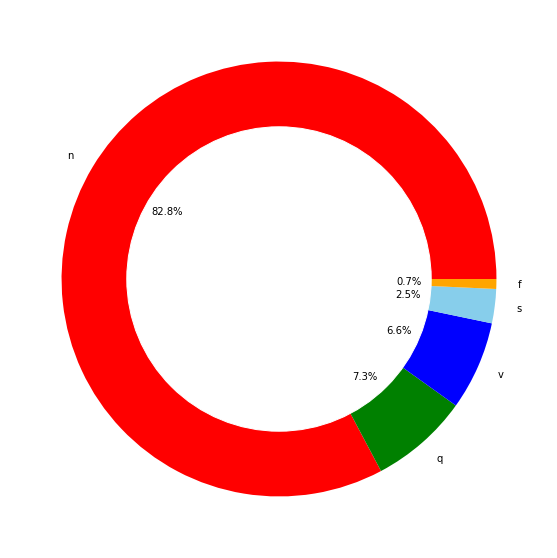

In [5]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(pieNum, labels=['n','q','v','s','f'],colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [6]:
from sklearn.utils import resample
df_1=train[train['y']==1.0]
df_2=train[train['y']==2.0]
df_3=train[train['y']==3.0]
df_4=train[train['y']==4.0]
df_0=(train[train['y']==0.0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

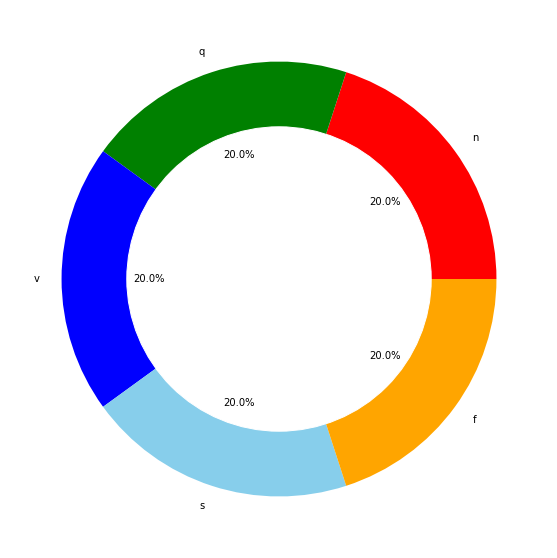

In [7]:
pieNum=train['y'].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(pieNum, labels=['n','q','v','s','f'],colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [13]:
X_train=train.drop('y',axis=1)
X_test=test.drop('y',axis=1)
y_train=train['y']
y_test=test['y']

In [9]:
from keras.utils import to_categorical 
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [14]:
X_train = X_train / 255
X_test = X_test / 255

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(100000, 187)
(100000,)
(21891, 187)
(21891,)


In [20]:
from keras.utils import to_categorical 
X_train = X_train.values.reshape(-1, 187, 1) 
X_test = X_test.values.reshape(-1, 187, 1)
y_train = to_categorical(y_train)

In [24]:
tmp = np.random.randint(0,60000,20000)
X_train_subset = X_train[tmp,:]
y_train_subset = y_train[tmp,:]
print(X_train_subset.shape)
print(y_train_subset.shape)

(20000, 187, 1)
(20000, 5)


In [43]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None,187,1), name='X') 
y = tf.placeholder(tf.float32, shape=(None,5), name='y')
with tf.name_scope('network'):
    conv1 = tf.layers.conv1d(X, filters=6, kernel_size=5, strides=1,padding='SAME', activation=tf.nn.relu, name='conv1')
    pool1 = tf.layers.max_pooling1d(conv1, pool_size=2, strides=2, name='pool1')
    conv2 = tf.layers.conv1d(pool1, filters=16, kernel_size=5, strides=1, padding='SAME', activation=tf.nn.relu, name='conv2')
    pool2 = tf.layers.max_pooling1d(conv2, pool_size=2, strides=2, name='pool2')
    flatten = tf.layers.flatten(pool2)
    fc1 = tf.layers.dense(flatten, units=120, activation=tf.nn.relu, name='fc1')
    fc2 = tf.layers.dense(fc1, units=84, activation=tf.nn.relu, name='fc2')
    logits = tf.layers.dense(fc2, units=5, name='logits')
    softmax = tf.nn.softmax(logits)


In [44]:
print(X.shape)
print(y.shape)

(?, 187, 1)
(?, 5)


In [45]:
pred = tf.arg_max(softmax, 1)
correct_pred = tf.equal(pred, tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [46]:
with tf.name_scope('loss'):
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=softmax, labels=y) 
    loss = tf.reduce_mean(loss)
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001) 
    solver = optimizer.minimize(loss)


In [48]:
with tf.name_scope('train'): 
    saver = tf.train.Saver()
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer()) 
        hist_loss = []
        hist_acc = []
        x_batches = np.array_split(X_train_subset, 10) 
        y_batches = np.array_split(y_train_subset, 10)
        for epoch in range(1500,2000):
            avg_loss = 0
            avg_acc = 0
            for b in range(0,10):
                batch_x = x_batches[b]
                batch_y = y_batches[b]
                _, loss_val, acc_val = sess.run([solver, loss, accuracy],
                                                feed_dict={X:batch_x, y:batch_y})
                avg_loss = avg_loss + loss_val
                avg_acc = avg_acc + acc_val
                avg_loss = avg_loss / 10
            avg_acc = avg_acc / 10
            hist_loss.append(avg_loss)
            hist_acc.append(avg_acc)
            if epoch % 20== 0:
                print('epoch:', '%04d'%(epoch),'cost:', '{:.4f}'.format(avg_loss), 'acc:', '{:.4f}'.format(avg_acc))
        saver.save(sess, 'model.ckpt')

epoch: 1500 cost: 0.1763 acc: 0.3277
epoch: 1520 cost: 0.1655 acc: 0.3423
epoch: 1540 cost: 0.1655 acc: 0.3423
epoch: 1560 cost: 0.1652 acc: 0.3425
epoch: 1580 cost: 0.1499 acc: 0.5870
epoch: 1600 cost: 0.1380 acc: 0.6676
epoch: 1620 cost: 0.1328 acc: 0.7106
epoch: 1640 cost: 0.1279 acc: 0.7488
epoch: 1660 cost: 0.1248 acc: 0.7758
epoch: 1680 cost: 0.1227 acc: 0.7935
epoch: 1700 cost: 0.1214 acc: 0.8035
epoch: 1720 cost: 0.1205 acc: 0.8108
epoch: 1740 cost: 0.1191 acc: 0.8220
epoch: 1760 cost: 0.1182 acc: 0.8303
epoch: 1780 cost: 0.1174 acc: 0.8377
epoch: 1800 cost: 0.1164 acc: 0.8468
epoch: 1820 cost: 0.1160 acc: 0.8502
epoch: 1840 cost: 0.1157 acc: 0.8528
epoch: 1860 cost: 0.1155 acc: 0.8562
epoch: 1880 cost: 0.1153 acc: 0.8606
epoch: 1900 cost: 0.1149 acc: 0.8655
epoch: 1920 cost: 0.1146 acc: 0.8692
epoch: 1940 cost: 0.1145 acc: 0.8694
epoch: 1960 cost: 0.1143 acc: 0.8722
epoch: 1980 cost: 0.1139 acc: 0.8740


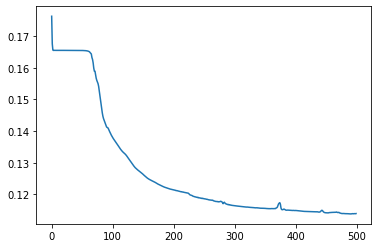

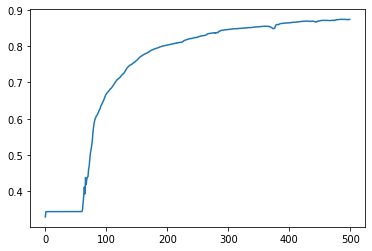

In [49]:
plt.figure()
plt.plot(hist_loss)
plt.figure()
plt.plot(hist_acc)